<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S10/CIFAR10_Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive and load required modules

In [2]:
from os.path import join
from google.colab import drive
import sys

# Mount the drive
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

LIBRARY_ROOT = "/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src"
sys.path.append(LIBRARY_ROOT)
sys.path.append(LIBRARY_ROOT + "/cnnlib")

Mounted at /content/drive


In [3]:
!pip install albumentations==0.4.5


In [4]:
from torchvision import datasets, transforms
from cnnlib.ModelBuilder import ModelTester
import torch
import Utility 
import DataUtility
import MetricsUtility
import ModelBuilder
from Functions import LossFn
import torch.nn.functional as F
import torch.optim as optim
from ModelBuilder import ModelBuilder
import models.Resnet as Resnet
import torch.nn as nn
from albumentations import *
from albumentations.pytorch import ToTensor
import numpy as np
from DataUtility import Alb
import cv2
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

  pip install torch-lr-finder -v --global-option="amp"


### Load the data and perform required transformations

Files already downloaded and verified
Files already downloaded and verified
Shape of a train data batch: torch.Size([128, 3, 32, 32])
Shape of a test data batch: torch.Size([128, 3, 32, 32])
Number of train images: 50000
Number of test images: 10000


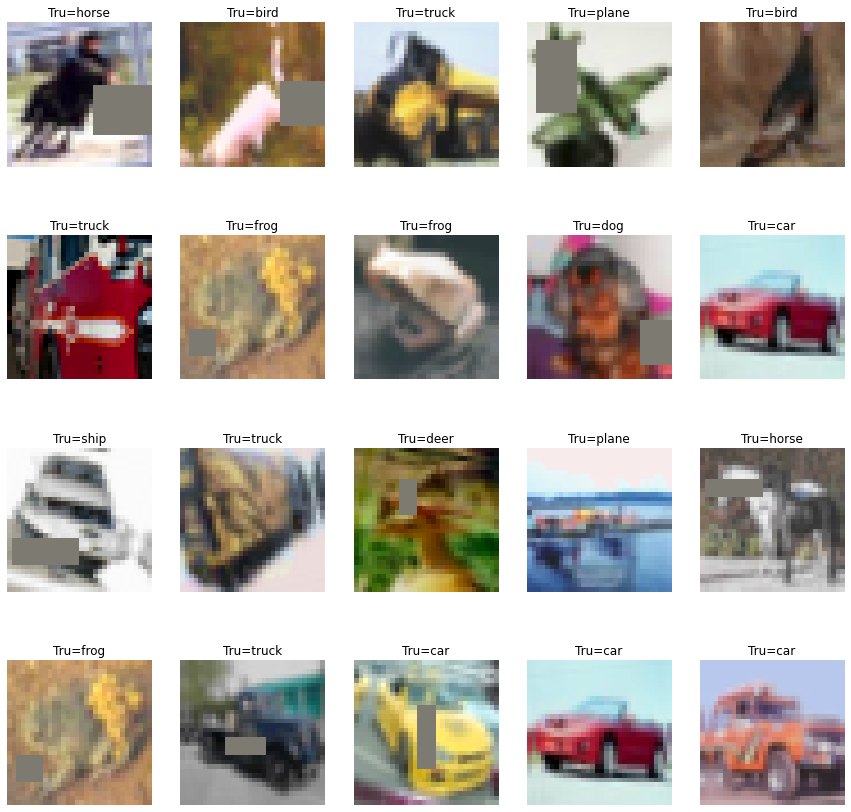

In [5]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

mean_array = np.array([*mean])


train_transforms = Compose([
          HorizontalFlip(p=0.5),
          RandomContrast(limit=0.2, p=0.5),
          RandomBrightness(limit=0.2, p=0.5),
          HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
          ShiftScaleRotate(
              shift_limit=0.0625, scale_limit=0.1, 
              rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
          CoarseDropout(max_holes=1, max_height=16, max_width=16, min_height=4,
						min_width=4, fill_value=np.array([*mean])*255.0, p=0.5),
          Normalize(mean, std),
          ToTensor()
        ])
  
test_transforms = Compose([
          Normalize(mean, std),
          ToTensor()
          ])

data=DataUtility.download_CIFAR10(Alb(train_transforms), Alb(test_transforms))
DataUtility.showLoaderImages(data.train, count=20, classes=data.classes, muSigmaPair=(mean, std))

## Initialize the network and view the summary

In [6]:
from torchsummary import summary
summary(Resnet.ResNet18().to(Utility.getDevice()), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


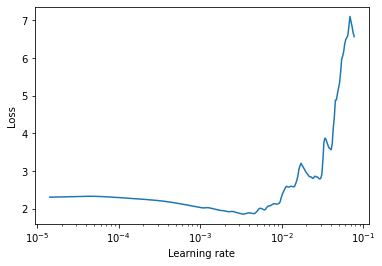

In [9]:
criterion = nn.CrossEntropyLoss()
net = Resnet.ResNet18().to(Utility.getDevice())
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
finder = LRFinder(net, optimizer, criterion, Utility.getDevice())

finder.range_test(data.train, val_loader=data.test, start_lr=1e-5, end_lr=1,
                     num_iter=len(data.train), step_mode="exp")
finder.plot()
finder.reset()


In [10]:
bestLR = finder.history["lr"][finder.history["loss"].index(finder.best_loss)]
print(f"Best LR: {bestLR}")

Best LR: 0.003403841347303053


## Train the network

In [11]:
optimizer = optim.SGD(net.parameters(), lr = bestLR, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=4, verbose=True, min_lr=1e-5)
builder = ModelBuilder(net, data, LossFn(criterion), optimizer, scheduler)
result = builder.fit(50)



Epoch: 1



Train Accuracy: 44.508%, Train Loss: 0.011794338002800941



Test Accuracy: 54.9%, Test Loss: 0.010216672904789448


Epoch: 2



Train Accuracy: 61.654%, Train Loss: 0.008402878418564796



Test Accuracy: 67.04%, Test Loss: 0.00731346569955349


Epoch: 3



Train Accuracy: 68.752%, Train Loss: 0.006917562801390886



Test Accuracy: 70.28%, Test Loss: 0.006801089271903038


Epoch: 4



Train Accuracy: 72.78%, Train Loss: 0.0060384031385183334



Test Accuracy: 75.64%, Test Loss: 0.005625195801258087


Epoch: 5



Train Accuracy: 75.83%, Train Loss: 0.005404375493526459



Test Accuracy: 79.12%, Test Loss: 0.004744310863316059


Epoch: 6



Train Accuracy: 78.116%, Train Loss: 0.004917853511869907



Test Accuracy: 80.26%, Test Loss: 0.004509891849011183


Epoch: 7



Train Accuracy: 79.678%, Train Loss: 0.0045649283565580845



Test Accuracy: 75.58%, Test Loss: 0.005906320177018642


Epoch: 8



Train Accuracy: 80.936%, Train Loss: 0.004277518950402737



Test Accuracy: 82.38%, Test Loss: 0.004078479018062353


Epoch: 9



Train Accuracy: 82.106%, Train Loss: 0.00399151211604476



Test Accuracy: 82.48%, Test Loss: 0.004051721189171076


Epoch: 10



Train Accuracy: 83.334%, Train Loss: 0.00374200358055532



Test Accuracy: 83.48%, Test Loss: 0.003994802478700876


Epoch: 11



Train Accuracy: 84.122%, Train Loss: 0.003558593336492777



Test Accuracy: 83.11%, Test Loss: 0.003849332220852375


Epoch: 12



Train Accuracy: 84.818%, Train Loss: 0.0034184176474809647



Test Accuracy: 84.95%, Test Loss: 0.0036379499360919


Epoch: 13



Train Accuracy: 85.28%, Train Loss: 0.0032471916638314724



Test Accuracy: 85.64%, Test Loss: 0.0034668550360947847


Epoch: 14



Train Accuracy: 86.37%, Train Loss: 0.003076092805713415



Test Accuracy: 85.69%, Test Loss: 0.0032690763473510742


Epoch: 15



Train Accuracy: 86.6%, Train Loss: 0.002968873828649521



Test Accuracy: 85.32%, Test Loss: 0.0035164272412657738


Epoch: 16



Train Accuracy: 87.33%, Train Loss: 0.002820254536345601



Test Accuracy: 83.61%, Test Loss: 0.003879714524373412


Epoch: 17



Train Accuracy: 87.898%, Train Loss: 0.002707601524889469



Test Accuracy: 86.4%, Test Loss: 0.003210473572835326


Epoch: 18



Train Accuracy: 88.218%, Train Loss: 0.002632934134453535



Test Accuracy: 87.53%, Test Loss: 0.0030041823629289865


Epoch: 19



Train Accuracy: 88.63%, Train Loss: 0.0025389494840055704



Test Accuracy: 86.41%, Test Loss: 0.0032439464703202248


Epoch: 20



Train Accuracy: 89.326%, Train Loss: 0.0023988031316548586



Test Accuracy: 88.41%, Test Loss: 0.0027378948871046305


Epoch: 21



Train Accuracy: 89.222%, Train Loss: 0.0023903059773147106



Test Accuracy: 87.92%, Test Loss: 0.0028737017419189215


Epoch: 22



Train Accuracy: 89.944%, Train Loss: 0.0022556500043720007



Test Accuracy: 88.58%, Test Loss: 0.0027312326710671186


Epoch: 23



Train Accuracy: 90.214%, Train Loss: 0.00217640888877213



Test Accuracy: 88.17%, Test Loss: 0.0029565212316811085


Epoch: 24



Train Accuracy: 90.456%, Train Loss: 0.0021351538598537445



Test Accuracy: 89.31%, Test Loss: 0.0025863887276500463


Epoch: 25



Train Accuracy: 90.978%, Train Loss: 0.0020274550188332796



Test Accuracy: 87.74%, Test Loss: 0.0031174947507679462


Epoch: 26



Train Accuracy: 91.23%, Train Loss: 0.0019530843710526824



Test Accuracy: 89.86%, Test Loss: 0.002559785731136799


Epoch: 27



Train Accuracy: 91.322%, Train Loss: 0.001928587444126606



Test Accuracy: 89.89%, Test Loss: 0.0024962129537016153


Epoch: 28



Train Accuracy: 91.64%, Train Loss: 0.0018588189268484712



Test Accuracy: 88.52%, Test Loss: 0.0028262219857424498


Epoch: 29



Train Accuracy: 91.794%, Train Loss: 0.0018133381381630898



Test Accuracy: 88.91%, Test Loss: 0.002687440486624837


Epoch: 30



Train Accuracy: 92.028%, Train Loss: 0.0017729923129081726



Test Accuracy: 90.53%, Test Loss: 0.0023913546465337276


Epoch: 31



Train Accuracy: 92.352%, Train Loss: 0.0016910405829548836



Test Accuracy: 89.07%, Test Loss: 0.0028301954735070467


Epoch: 32



Train Accuracy: 92.638%, Train Loss: 0.0016624502604827285



Test Accuracy: 90.27%, Test Loss: 0.00245579588226974


Epoch: 33



Train Accuracy: 92.876%, Train Loss: 0.001594078610651195



Test Accuracy: 89.38%, Test Loss: 0.0026260651648044586


Epoch: 34



Train Accuracy: 92.864%, Train Loss: 0.0015780257526785135



Test Accuracy: 89.07%, Test Loss: 0.002823799615725875


Epoch: 35



Train Accuracy: 92.85%, Train Loss: 0.0015617465833202004



Test Accuracy: 89.8%, Test Loss: 0.00257730670273304
Epoch    35: reducing learning rate of group 0 to 3.2090e-04.


Epoch: 36



Train Accuracy: 94.656%, Train Loss: 0.0011672709370031953



Test Accuracy: 91.68%, Test Loss: 0.002052621217444539


Epoch: 37



Train Accuracy: 95.492%, Train Loss: 0.0010237176902592182



Test Accuracy: 91.89%, Test Loss: 0.002019005361944437


Epoch: 38



Train Accuracy: 95.62%, Train Loss: 0.0009928428335115314



Test Accuracy: 91.98%, Test Loss: 0.00198007607832551


Epoch: 39



Train Accuracy: 95.89%, Train Loss: 0.0009337500669062138



Test Accuracy: 92.01%, Test Loss: 0.0019764876924455166


Epoch: 40



Train Accuracy: 96.122%, Train Loss: 0.0008916024817153811



Test Accuracy: 92.11%, Test Loss: 0.0019530581776052713


Epoch: 41



Train Accuracy: 96.078%, Train Loss: 0.0009078657021746039



Test Accuracy: 92.35%, Test Loss: 0.001962719950824976


Epoch: 42



Train Accuracy: 96.256%, Train Loss: 0.000871739350259304



Test Accuracy: 92.04%, Test Loss: 0.0019881962798535824


Epoch: 43



Train Accuracy: 96.204%, Train Loss: 0.0008595222025178373



Test Accuracy: 92.07%, Test Loss: 0.0019686066079884768


Epoch: 44



Train Accuracy: 96.368%, Train Loss: 0.0008577207918278873



Test Accuracy: 92.04%, Test Loss: 0.001939154346473515


Epoch: 45



Train Accuracy: 96.456%, Train Loss: 0.0008365676621906459



Test Accuracy: 92.1%, Test Loss: 0.0019829943776130676


Epoch: 46



Train Accuracy: 96.618%, Train Loss: 0.0008011067984625697



Test Accuracy: 92.28%, Test Loss: 0.0019372281385585666


Epoch: 47



Train Accuracy: 96.49%, Train Loss: 0.0008063353598117828



Test Accuracy: 92.19%, Test Loss: 0.001984259346500039


Epoch: 48



Train Accuracy: 96.588%, Train Loss: 0.0007922212244011462



Test Accuracy: 92.28%, Test Loss: 0.002003079280257225


Epoch: 49



Train Accuracy: 96.528%, Train Loss: 0.0007993561448529363



Test Accuracy: 92.28%, Test Loss: 0.0019630168098956347


Epoch: 50



Train Accuracy: 96.68%, Train Loss: 0.0007762210443615913



Test Accuracy: 92.46%, Test Loss: 0.001965112751349807


## Plot metrics and loss

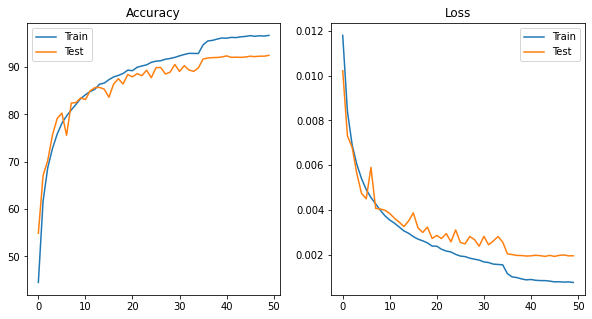

In [12]:
MetricsUtility.plotMetrics(result)

## View miss classified images


[[940   3  11   6   3   2   2   2  21  10]
 [  3 964   1   1   0   0   0   0   4  27]
 [ 14   0 897  20  22  10  22   9   3   3]
 [  5   3  24 823  30  71  27   8   1   8]
 [  4   1  11  22 928   8  11  15   0   0]
 [  4   1  16  73  17 866   5  15   0   3]
 [  3   0   8  13   5   4 963   1   1   2]
 [  7   0   7   8  12  14   1 949   1   1]
 [ 15   6   2   3   1   0   1   0 959  13]
 [  5  23   1   2   0   1   3   1   7 957]]


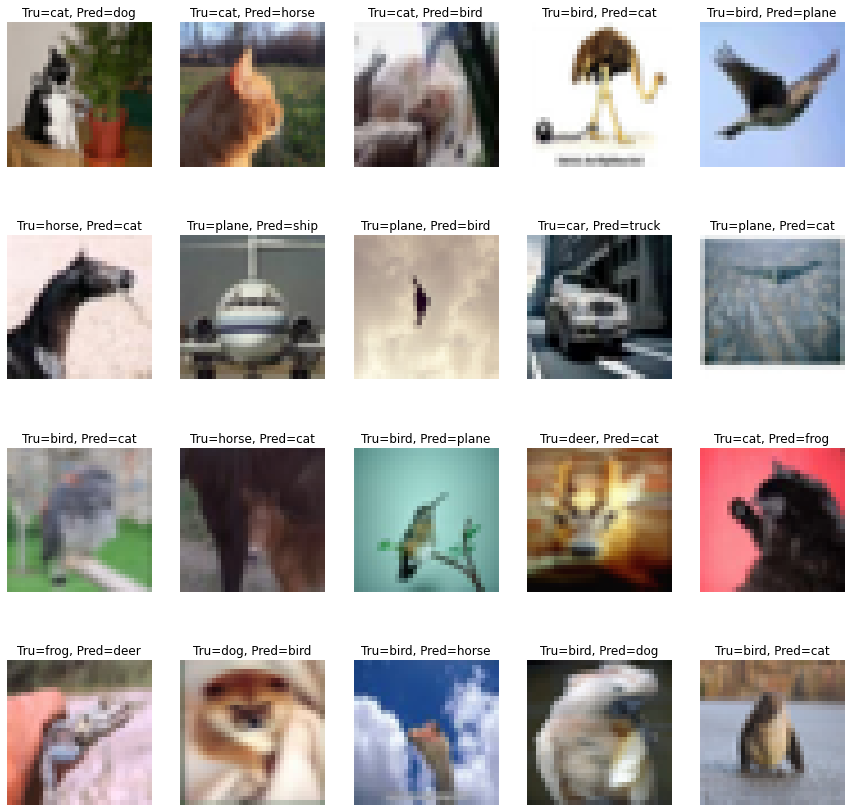

In [13]:
cpu = torch.device("cpu")
testResult = ModelTester().test(net, data.test, LossFn(F.nll_loss))
metrics = MetricsUtility.computeMetrics(testResult.data, testResult.predictions, testResult.targets)
DataUtility.showRandomImages(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), metrics.miss_classified_predictions.to(cpu), data.classes, muSigmaPair=(mean, std))

## Visualize GradCam

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


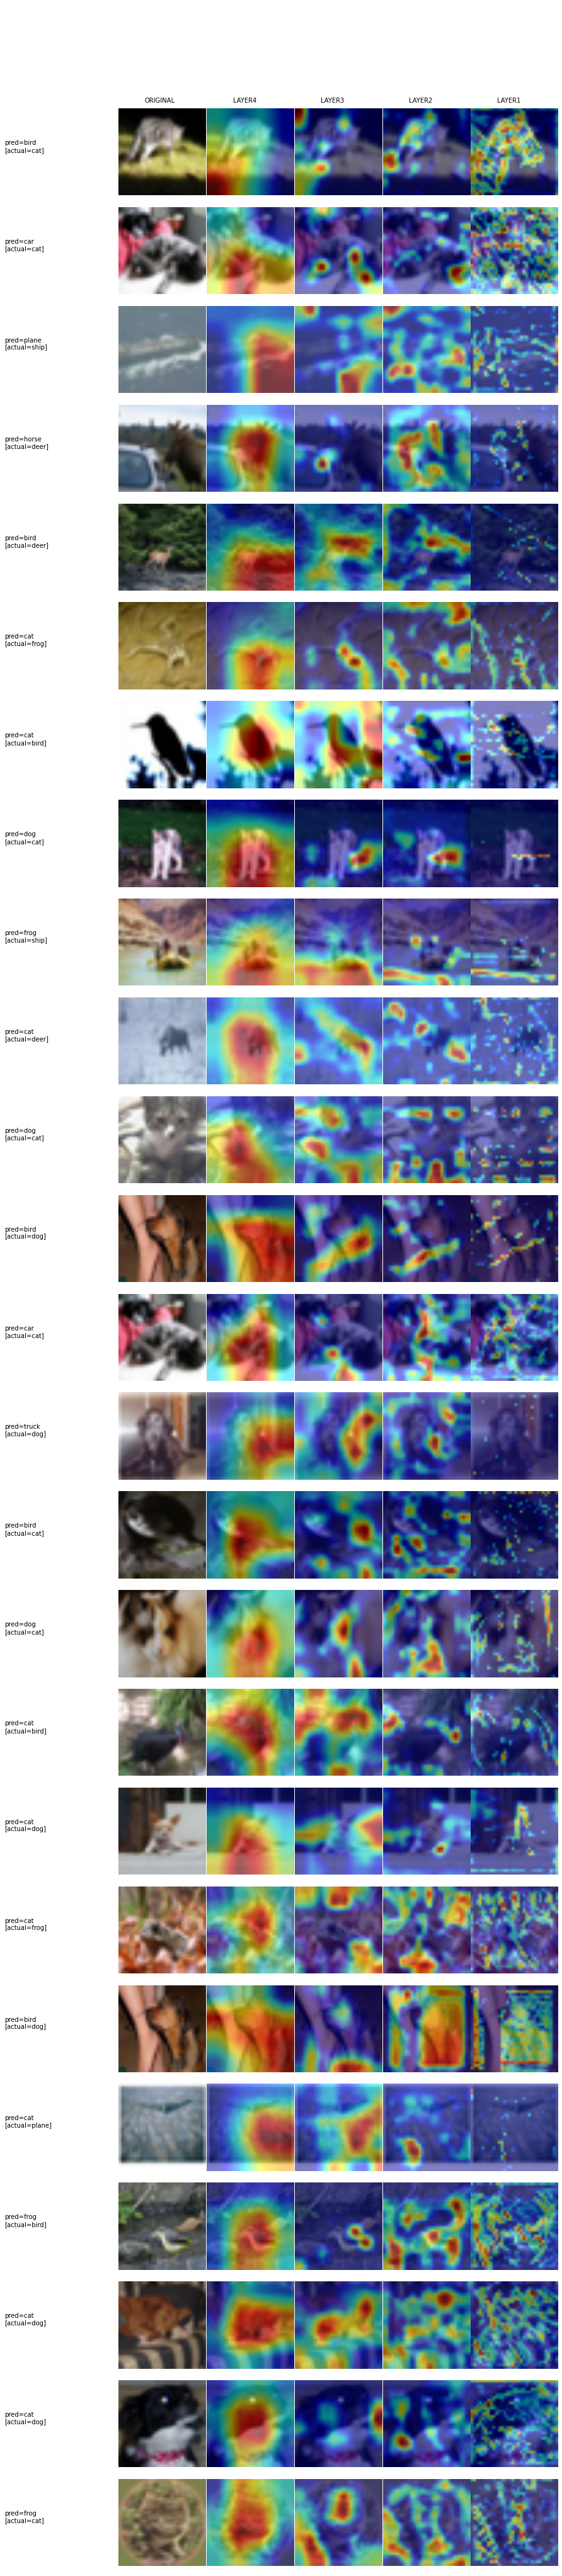

In [17]:
from GradCam import GradCam, Analyzer

cpuNet = net.to(cpu)
layers = ["layer4", "layer3", "layer2", "layer1"]
analyzer = Analyzer(GradCam(cpuNet, layers))

analyzer.visualize(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), data.classes, muSigPair=(mean, std), figSize=(15, 75), count=25)